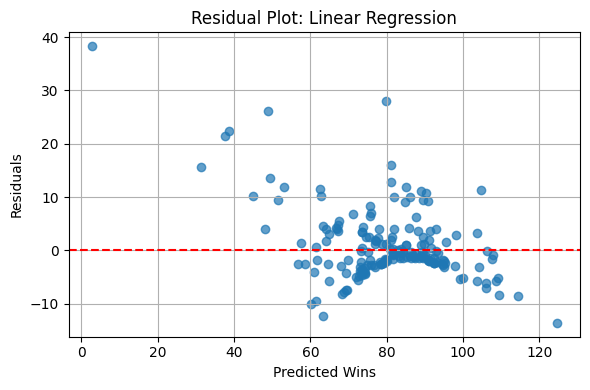

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.21198e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


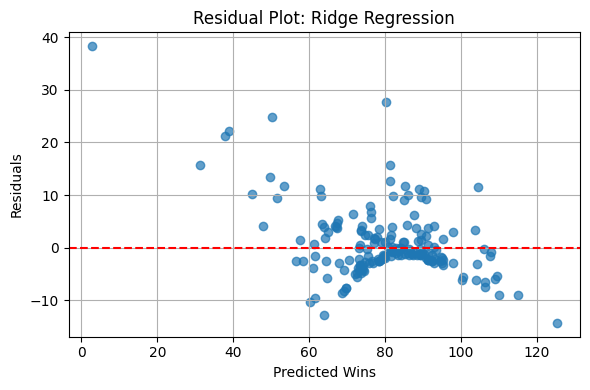

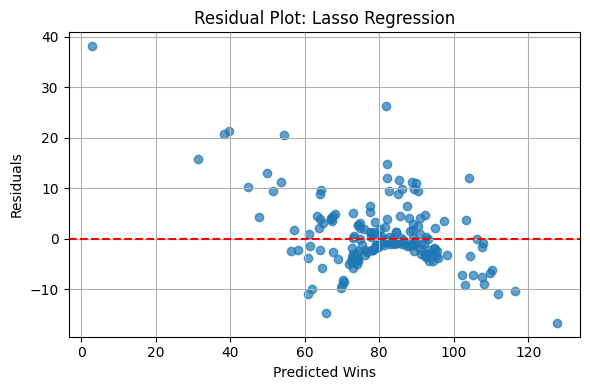

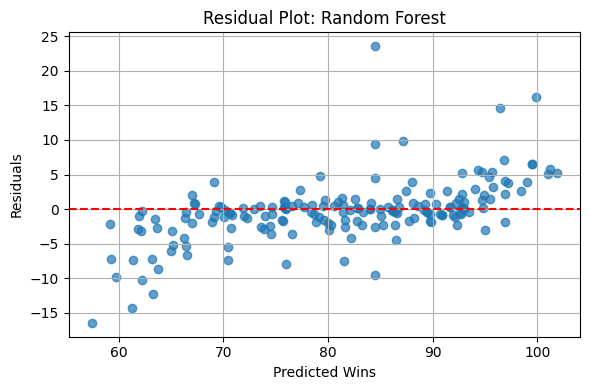

📊 Model Performance on Test Data (2019–2024):


,Model,R²,MAE,RMSE,MBE
3,Random Forest,0.900694,2.745722,4.442859,0.290722
2,Lasso Regression,0.762645,4.553874,6.868675,-0.580714
1,Ridge Regression,0.761228,4.510516,6.889154,-0.853713
0,Linear Regression,0.759587,4.505545,6.912781,-0.933171


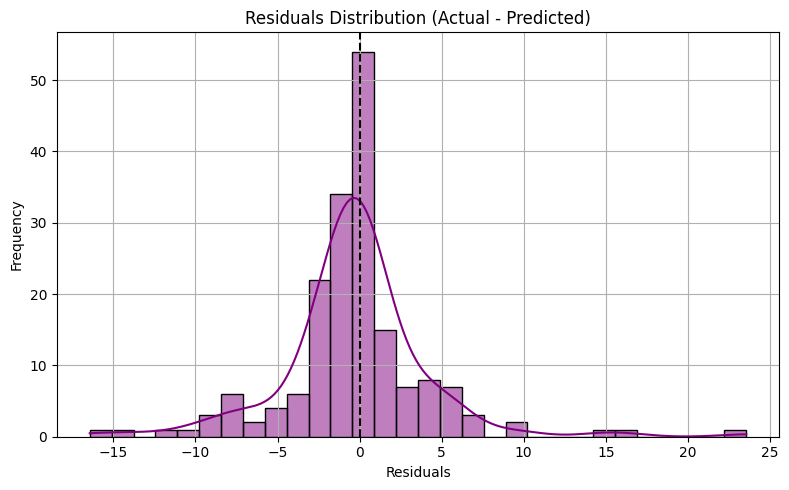

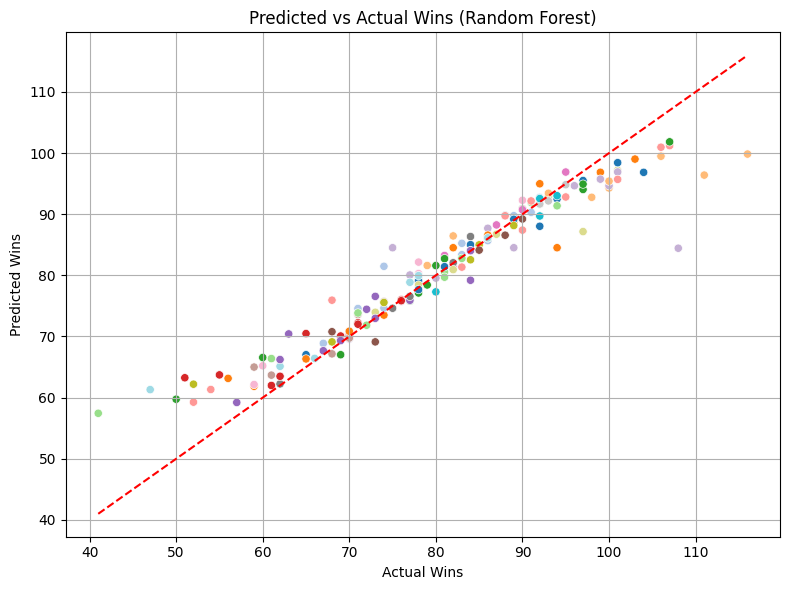

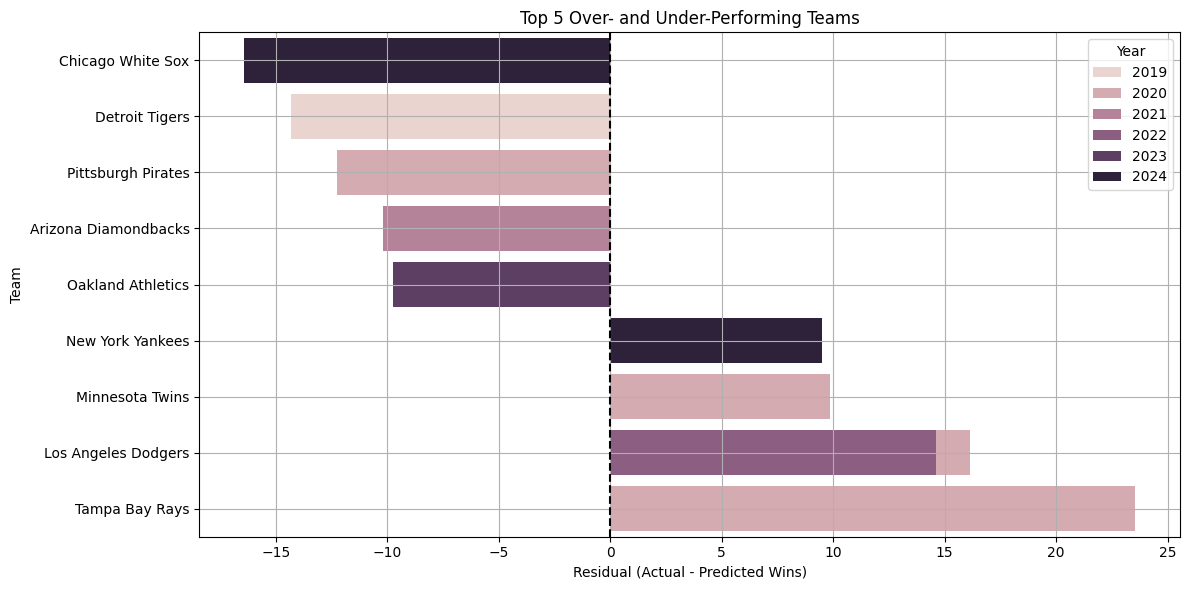

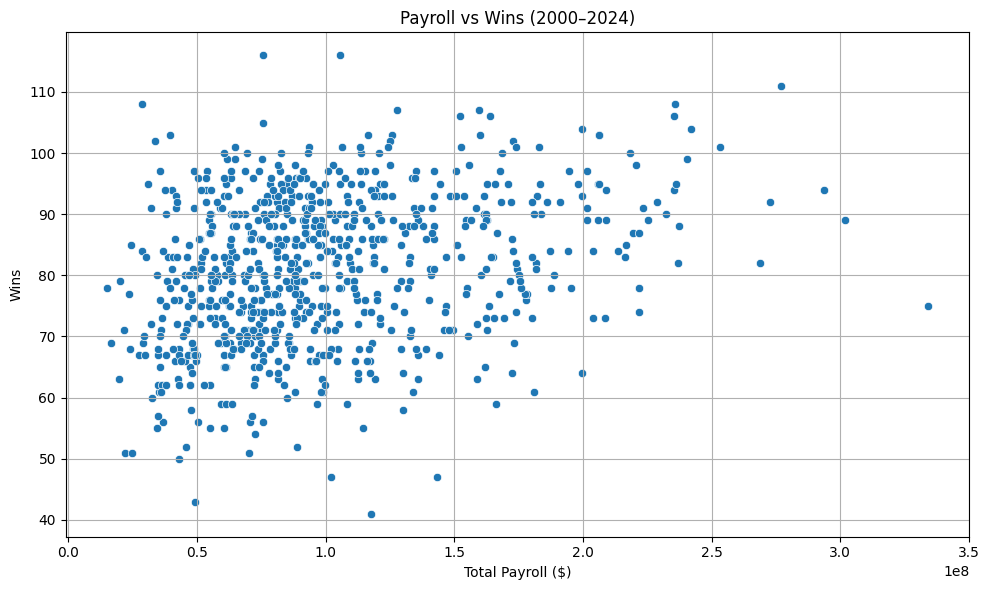

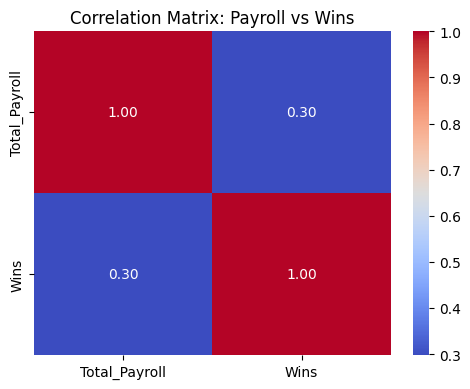

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


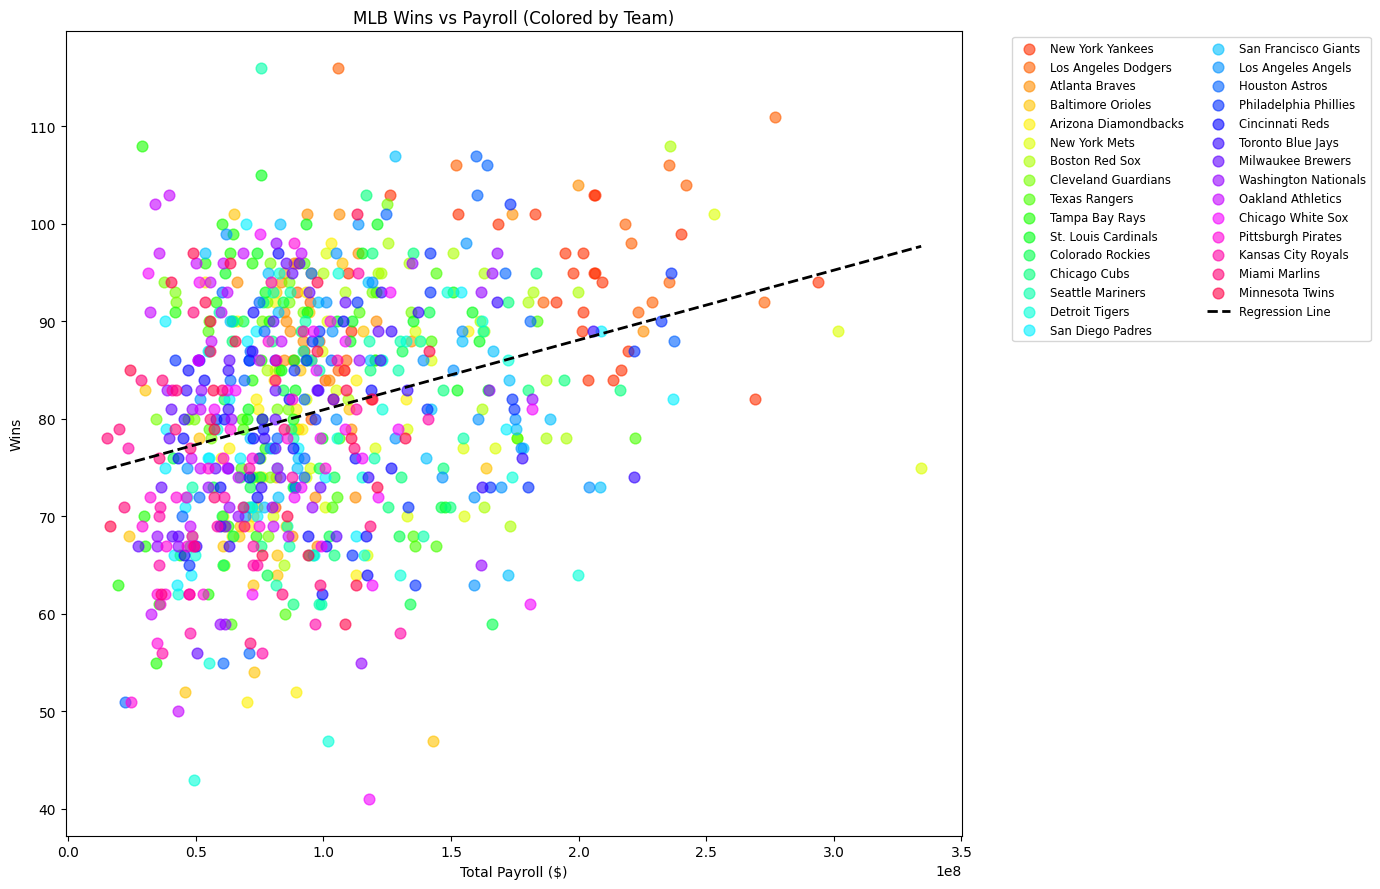

In [36]:
# 📦 Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 📂 Load training and testing datasets
train = pd.read_csv('/content/MLB_train.csv')
test = pd.read_csv('/content/MLB_test.csv')

# 🧮 Add new features: log salary and payroll per win
for df in [train, test]:
    df['Payroll_per_Win'] = df['Total_Payroll'] / df['Wins']
    df['Log_Salary'] = np.log(df['Total_Payroll'])
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

# 🎯 Define features and targets
features = ['Total_Payroll', 'Payroll_per_Win', 'Log_Salary']
X_train, y_train = train[features], train['Wins']
X_test, y_test = test[features], test['Wins']

# 🤖 Set up 4 models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

model_predictions = {}
metrics = []

# ➕ Mean Bias Error (optional)
def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)

# 🚀 Train, predict, evaluate, and show residual plots
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    residuals = y_test - preds
    model_predictions[name] = {
        'model': model,
        'y_pred': preds,
        'residuals': residuals
    }

    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mbe = mean_bias_error(y_test, preds)
    metrics.append([name, r2, mae, rmse, mbe])

    plt.figure(figsize=(6, 4))
    plt.scatter(preds, residuals, alpha=0.7)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Wins")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot: {name}")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{name.lower().replace(' ', '_')}__residual_plot.png")
    plt.show()  # ✅ Show inline

# 🧾 Save performance comparison
results_df = pd.DataFrame(metrics, columns=['Model', 'R²', 'MAE', 'RMSE', 'MBE'])
results_df = results_df.sort_values(by='R²', ascending=False)
print("📊 Model Performance on Test Data (2019–2024):")
display(results_df)
results_df.to_csv("model_comparison_metrics.csv", index=False)

# ✅ Use best model (Random Forest)
best = model_predictions['Random Forest']
test['Predicted_Wins'] = best['y_pred']
test['Residual'] = best['residuals']

# 📊 Residual histogram
plt.figure(figsize=(8, 5))
sns.histplot(test['Residual'], bins=30, kde=True, color='purple')
plt.axvline(0, linestyle='--', color='black')
plt.title("Residuals Distribution (Actual - Predicted)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig("residual_plot_random_forest.png")
plt.show()

# 📈 Predicted vs Actual Wins (scatter)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=best['y_pred'], hue=test['Team'], palette='tab20', legend=False)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Wins')
plt.ylabel('Predicted Wins')
plt.title('Predicted vs Actual Wins (Random Forest)')
plt.grid(True)
plt.tight_layout()
plt.savefig("predicted_vs_actual_wins.png")
plt.show()

# 🔍 Over- and under-performers
sorted_test = test.sort_values('Residual')
top_under = sorted_test.head(5)
top_over = sorted_test.tail(5)

plt.figure(figsize=(12, 6))
sns.barplot(x='Residual', y='Team', data=pd.concat([top_under, top_over]), hue='Year', dodge=False)
plt.axvline(0, color='black', linestyle='--')
plt.title('Top 5 Over- and Under-Performing Teams')
plt.xlabel('Residual (Actual - Predicted Wins)')
plt.ylabel('Team')
plt.grid(True)
plt.tight_layout()
plt.savefig("over_under_performers.png")
plt.show()

# 💸 Payroll vs Wins Scatter
combined = pd.concat([train, test])
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined, x='Total_Payroll', y='Wins')
plt.title('Payroll vs Wins (2000–2024)')
plt.xlabel('Total Payroll ($)')
plt.ylabel('Wins')
plt.grid(True)
plt.tight_layout()
plt.savefig("payroll_vs_wins.png")
plt.show()

# 🔥 Correlation Heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(combined[['Total_Payroll', 'Wins']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix: Payroll vs Wins")
plt.tight_layout()
plt.savefig("correlation_matrix.png")
plt.show()

# 🌈 Wins vs Payroll Scatter (Team Colored)
teams = combined['Team'].unique()
palette = sns.color_palette("hsv", len(teams))
team_colors = dict(zip(teams, palette))

plt.figure(figsize=(14, 9))
for team in teams:
    team_df = combined[combined['Team'] == team]
    plt.scatter(team_df['Total_Payroll'], team_df['Wins'], label=team,
                color=team_colors[team], alpha=0.6, s=60)

# 📈 Regression Line
linreg = LinearRegression()
X_all = combined[['Total_Payroll']]
y_all = combined['Wins']
linreg.fit(X_all, y_all)
x_range = np.linspace(X_all.min(), X_all.max(), 500)
y_line = linreg.predict(x_range)
plt.plot(x_range, y_line, color='black', linestyle='--', linewidth=2, label='Regression Line')

plt.title("MLB Wins vs Payroll (Colored by Team)")
plt.xlabel("Total Payroll ($)")
plt.ylabel("Wins")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize='small')
plt.tight_layout()
plt.savefig("mlb_wins_vs_payroll_colored.png")
plt.show()




In [37]:
import joblib

# Save trained Random Forest model to a file
joblib.dump(model_predictions['Random Forest']['model'], 'model.pkl')

# Download to local machine
from google.colab import files
files.download('model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>